26.577936994048187
+-------------------------+-----------------------+----------------------+----------------------+----------------------+
|                       N |              Integral |            Std Error |            Rel Error |             MC Error |
+=========================+=======================+======================+======================+======================+
|    1.000000000000000000 | 39.809175586907933564 | 0.000000000000000000 | 0.541000345299662011 | 0.000000000000000000 |
+-------------------------+-----------------------+----------------------+----------------------+----------------------+
|    2.000000000000000000 | 33.414261722208308925 | 1.323896467234693564 | 0.293455292472579787 | 0.936136169570565668 |
+-------------------------+-----------------------+----------------------+----------------------+----------------------+
|    4.000000000000000000 | 18.450503908144511911 | 6.088941945619769314 | 0.285786945491180167 | 3.044470972809884657 |
+------------

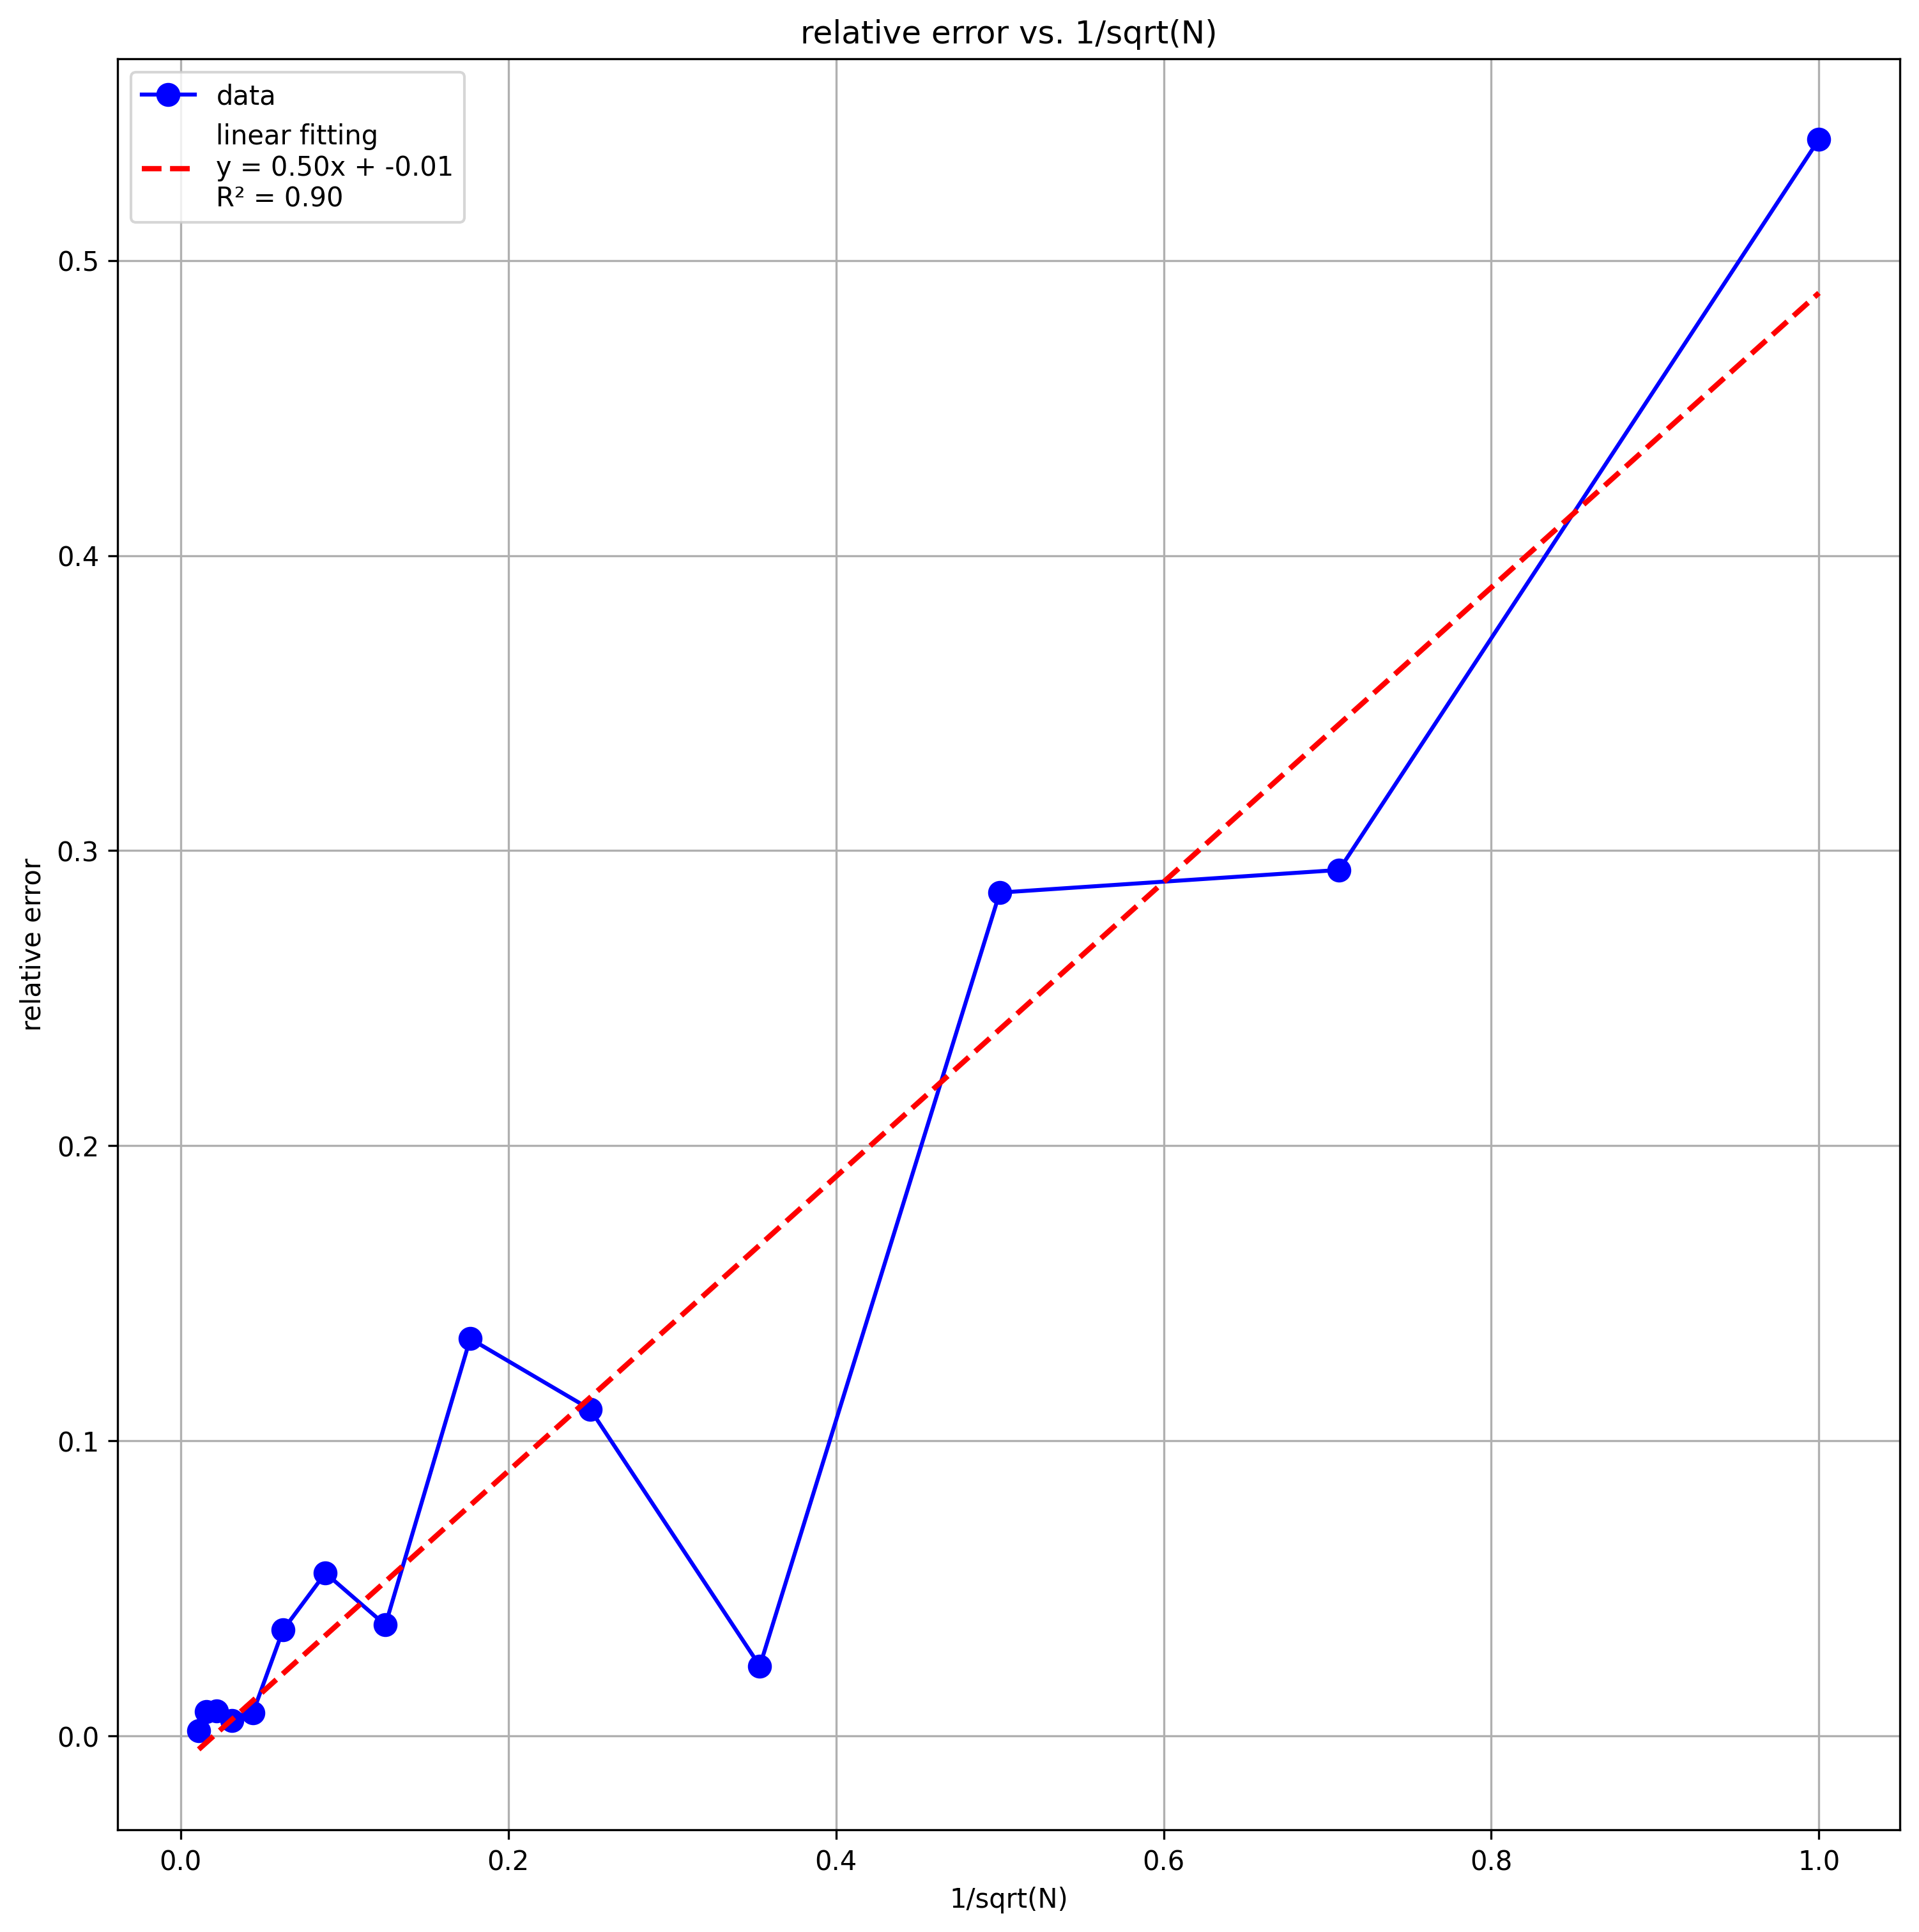

斜率: 0.4990
截距: -0.0100
R平方: 0.9019


In [34]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats  # 用于统计分析和线性回归
from numba import jit  # 用于加速函数计算
from tabulate import tabulate  # 用于生成格式化的表格

# 使用numba加速的函数，计算10维向量x各元素和的平方
@jit(nopython=True)
def func(x):
    s = np.sum(x)
    return s * s


# 蒙特卡洛积分计算函数，N为样本数量
@jit(nopython=True)
def mc_integral(N):
    total = 0  # 存储积分值的累加和
    total_sq = 0  # 存储积分值平方的累加和
    true_value = 155.0 / 6.0  # 理论精确值，计算10维超立方体上(sum x_i)^2的积分
    for _ in range(N):
        x = np.random.uniform(0, 1, 10)  # 生成10维均匀分布随机样本
        I_val = func(x)  # 计算当前样本的函数值
        total += I_val  # 累加函数值
        total_sq += I_val * I_val  # 累加函数值的平方
    I = total / N  # 计算蒙特卡洛积分估计值
    # 计算标准误差：sqrt(Var/N)，其中Var是样本方差
    standard_error = np.sqrt((total_sq / N - I * I) / N)
    # 计算相对误差：|估计值 - 真实值| / 真实值
    relative_error = np.abs(I - true_value) / true_value
    return I, standard_error, relative_error


# 测试N=16时的积分估计值
I = mc_integral(16)[0]
print(I)

# 生成不同样本量下的误差数据
@jit(nopython=True)
def error_array(num):
    I_array = []  # 存储不同N对应的积分估计值
    standard_error_array = []  # 存储不同N对应的标准误差
    relative_error_array = []  # 存储不同N对应的相对误差
    montecar_error_array = [] # 存储不同N对应的蒙特卡洛误差
    for i in num:
        # 调用蒙特卡洛积分函数获取结果
        I, standard_error, relative_error = mc_integral(i)
        I_array.append(I)
        standard_error_array.append(standard_error)
        relative_error_array.append(relative_error)
        montecar_error_array.append(standard_error / np.sqrt(i))
    return I_array, standard_error_array, relative_error_array, montecar_error_array


# 生成样本数量数组：2^0, 2^1, ..., 2^13，共14个点
num = np.logspace(0, 13, num=14, base=2, dtype=int)

# 获取不同样本量下的积分结果和误差
I_array, standard_error_array, relative_error_array, montecar_error_array = error_array(num)

# 使用tabulate库格式化输出结果表格
headers = ["N", "Integral", "Std Error", "Rel Error", "MC Error"]
data = zip(num, I_array, standard_error_array, relative_error_array, montecar_error_array)
print(tabulate(data, headers=headers, tablefmt="grid", floatfmt="20.18f"))

# 准备绘图数据：x=1/sqrt(N)，y=相对误差
x = 1 / np.sqrt(num)
y = relative_error_array

# 创建画布
plt.figure(figsize=(12, 12), dpi=300)
# 绘制数据点
plt.plot(x, y, "bo-", markersize=8, label="data")

# 进行线性回归分析
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value**2  # 计算R平方值

# 生成拟合直线数据
x_fit = np.array([np.min(x), np.max(x)])
y_fit = slope * x_fit + intercept

# 绘制拟合直线
plt.plot(
    x_fit,
    y_fit,
    "r--",
    linewidth=2,
    label=f"linear fitting\ny = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.2f}",
)

# 添加图例、标签和标题
plt.legend(loc="best")
plt.xlabel("1/sqrt(N)")  # 横坐标：1/根号N，预期与相对误差成线性关系
plt.ylabel("relative error")  # 纵坐标：相对误差
plt.title("relative error vs. 1/sqrt(N)")  # 标题
plt.grid(True)  # 显示网格

# 显示图形
plt.show()

# 输出线性回归结果
print(f"斜率: {slope:.4f}")  # 预期接近理论收敛速率O(1/sqrt(N))的系数
print(f"截距: {intercept:.4f}")  # 预期接近0，表示系统误差较小
print(f"R平方: {r_squared:.4f}")  # 接近1表示线性关系显著